In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/vegetation_dataset"

'vegetation segmentation.v2i.yolov8.zip'


In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/vegetation_dataset/vegetation segmentation.v2i.yolov8.zip"
extract_path = "/content/vegetation_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted dataset to:", extract_path)

Extracted dataset to: /content/vegetation_dataset


In [ ]:
!pip install -q ultralytics opencv-python-headless matplotlib seaborn PyYAML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00


In [ ]:
import os, glob, yaml, shutil
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import ultralytics

print("PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")
try:
  print("Ultralytics YOLO version:", ultralytics.__version__)

except Exception as e:
    print("Ultralytics import error:", e)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch device: cpu
Ultralytics YOLO version: 8.3.220


In [ ]:
DATA_ROOT = "/content/vegetation_dataset"

def find_split_paths(root):
    train_candidates = ["train", "training", "Train"]
    val_candidates   = ["valid", "val", "validation", "Valid"]
    found = {"train_images":None, "train_labels":None, "val_images":None, "val_labels":None}
    for t in train_candidates:
        tpath = os.path.join(root, t)
        if os.path.isdir(tpath):

            for sub in ["images","image","imgs","img","Images"]:
                if os.path.isdir(os.path.join(tpath, sub)):
                    found["train_images"] = os.path.join(tpath, sub)
                if os.path.isdir(os.path.join(tpath, "labels")):
                    found["train_labels"] = os.path.join(tpath, "labels")

            if found["train_images"] is None:
                found["train_images"] = tpath
            if found["train_labels"] is None and os.path.isdir(os.path.join(tpath, "labels")):
                found["train_labels"] = os.path.join(tpath, "labels")
    for v in val_candidates:
        vpath = os.path.join(root, v)
        if os.path.isdir(vpath):
            for sub in ["images","image","imgs","img","Images"]:
                if os.path.isdir(os.path.join(vpath, sub)):
                    found["val_images"] = os.path.join(vpath, sub)
            if found["val_images"] is None:
                found["val_images"] = vpath
            if os.path.isdir(os.path.join(vpath, "labels")):
                found["val_labels"] = os.path.join(vpath, "labels")

    if found["train_images"] is None:
        for p in glob.glob(os.path.join(root, "*/images")):
            if "train" in p.lower(): found["train_images"] = p
            if "valid" in p.lower() or "val" in p.lower(): found["val_images"] = p
    return found

paths = find_split_paths(DATA_ROOT)
print("Detected paths:")
for k,v in paths.items():
    print(f"  {k}: {v}")

if paths["train_images"] is None:
    print("\nTop-level entries under dataset root:")
    print(os.listdir(DATA_ROOT))
    raise SystemExit("Could not auto-detect train images folder. Rename your folders to 'train' and 'valid' or 'val' or place images under train/images and valid/images.")


Detected paths:
  train_images: /content/vegetation_dataset/train/images
  train_labels: /content/vegetation_dataset/train/labels
  val_images: /content/vegetation_dataset/valid/images
  val_labels: /content/vegetation_dataset/valid/labels


In [ ]:
train_labels_dir = paths.get("train_labels")
if train_labels_dir is None:
    parent = os.path.dirname(paths["train_images"])
    candidate = os.path.join(parent, "labels")
    if os.path.isdir(candidate):
        train_labels_dir = candidate
        paths["train_labels"] = candidate

print("Using train labels dir:", train_labels_dir)

def infer_num_classes(labels_dir):
    if labels_dir is None:
        return None
    max_cls = -1
    for f in glob.glob(os.path.join(labels_dir, "*.txt")):
        with open(f, "r") as fh:
            for line in fh:
                line = line.strip()
                if not line: continue
                cls = int(line.split()[0])
                if cls > max_cls: max_cls = cls
    return max_cls + 1 if max_cls >= 0 else None

num_classes = infer_num_classes(train_labels_dir)
if num_classes is None:
    print("No label files found or unable to infer classes. Defaulting to 1 class.")
    num_classes = 1

class_names = [f"class_{i}" for i in range(num_classes)]
print("Inferred number of classes:", num_classes)
print("Class names:", class_names)


Using train labels dir: /content/vegetation_dataset/train/labels
Inferred number of classes: 1
Class names: ['class_0']


In [ ]:
dataset_yaml = {
    "path": os.path.abspath(DATA_ROOT),
    "train": os.path.relpath(paths["train_images"], start=DATA_ROOT) if paths["train_images"] else "train/images",
    "val": os.path.relpath(paths["val_images"],   start=DATA_ROOT) if paths["val_images"] else "valid/images",
    "names": class_names
}

yaml_path = "vegetation_data.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(dataset_yaml, f, sort_keys=False)

print("Wrote dataset YAML to", yaml_path)
print("---")
print(open(yaml_path).read())


Wrote dataset YAML to vegetation_data.yaml
---
path: /content/vegetation_dataset
train: train/images
val: valid/images
names:
- class_0



In [10]:
from ultralytics import YOLO

base_model = "yolov8n.pt"

model = YOLO(base_model)

training_kwargs = {
    "data": yaml_path,
    "epochs": 50,
    "imgsz": 640,
    "batch": 8,
    "name": "vegetation_yolov8",
}

print("Starting training with args:", training_kwargs)
model.train(**training_kwargs)
print("Training finished. Check runs/detect/vegetation_yolov8 for logs and weights.")


Starting training with args: {'data': 'vegetation_data.yaml', 'epochs': 50, 'imgsz': 640, 'batch': 8, 'name': 'vegetation_yolov8'}
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=vegetation_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vegetation_yolov8, nbs=64

In [13]:
# 8. Run validation again and print detailed metrics (mAP, Precision, Recall, F1, Accuracy)

res = model.val(data=yaml_path, split="val")  # validation on val set

# ---- Inspect what metrics are available ----
print("Available attributes in validation result object:\n", dir(res))

print("\n📊 --- VALIDATION METRICS SUMMARY ---")
try:
    # --- Detection metrics ---
    print(f"mAP (0.5:0.95): {res.box.map:.4f}")
    print(f"mAP50: {res.box.map50:.4f}")
    print(f"mAP75: {res.box.map75:.4f}")
    print(f"Precision: {res.box.mp:.4f}")
    print(f"Recall: {res.box.mr:.4f}")
    print(f"F1-score: {res.box.mf1:.4f}")

    # Accuracy (derived) – if possible
    accuracy = (res.box.mp + res.box.mr) / 2
    print(f"Accuracy (approx): {accuracy:.4f}")

except AttributeError:
    try:
        # --- Segmentation metrics (for YOLOv8-seg models) ---
        print(f"mAP (0.5:0.95): {res.seg.map:.4f}")
        print(f"mAP50: {res.seg.map50:.4f}")
        print(f"mAP75: {res.seg.map75:.4f}")
        print(f"Precision: {res.seg.mp:.4f}")
        print(f"Recall: {res.seg.mr:.4f}")
        print(f"F1-score: {res.seg.mf1:.4f}")
        accuracy = (res.seg.mp + res.seg.mr) / 2
        print(f"Accuracy (approx): {accuracy:.4f}")
    except Exception as e:
        print("Unable to find standard metrics in result object:", e)
        print("Ultralytics will print metrics above; check runs/*/results.csv for detailed values.")

print("\n✅ Validation completed. Check plots and confusion matrices in 'runs/detect/<run_name>/'")


Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2174.5±625.7 MB/s, size: 176.9 KB)
val: Scanning /content/vegetation_dataset/valid/labels.cache... 59 images, 9 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 59/59 94.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.3it/s 12.3s
                   all         59        132      0.604      0.621      0.638      0.422
Speed: 2.7ms preprocess, 188.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /content/runs/detect/val2
Available attributes in validation result object:
 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__set

In [12]:
# 9. Inference on validation images and save results
preds = model.predict(source=paths["val_images"], imgsz=640, conf=0.25, save=True)
print("Saved predictions. Check runs/*/predict for output annotated images.")


image 1/59 /content/vegetation_dataset/valid/images/0-0-20_png.rf.fc47a980f69ef8a4fca62f2ba0020b5c.jpg: 640x640 1 class_0, 247.4ms
image 2/59 /content/vegetation_dataset/valid/images/0-10-9_png.rf.9d52e3f2e793ce21ce737e4c69f66a70.jpg: 640x640 2 class_0s, 177.8ms
image 3/59 /content/vegetation_dataset/valid/images/0-11-46_png.rf.1252e9afbcafddbf1ffd8d6ff6c7dff5.jpg: 640x640 1 class_0, 242.7ms
image 4/59 /content/vegetation_dataset/valid/images/0-12-2_png.rf.88338502f55abbbdb215779d568397d4.jpg: 640x640 1 class_0, 223.7ms
image 5/59 /content/vegetation_dataset/valid/images/0-14-44_png.rf.52f4eefd419b51e697ea101f422abf17.jpg: 640x640 1 class_0, 233.5ms
image 6/59 /content/vegetation_dataset/valid/images/0-14-7_png.rf.b3ec9ff5ed49936c9a6ec843685be78d.jpg: 640x640 7 class_0s, 255.9ms
image 7/59 /content/vegetation_dataset/valid/images/0-15-3_png.rf.804bf757936551ec76b873f481adfcbb.jpg: 640x640 3 class_0s, 224.1ms
image 8/59 /content/vegetation_dataset/valid/images/0-16-19_png.rf.63949a8851

Found predicted images: 59


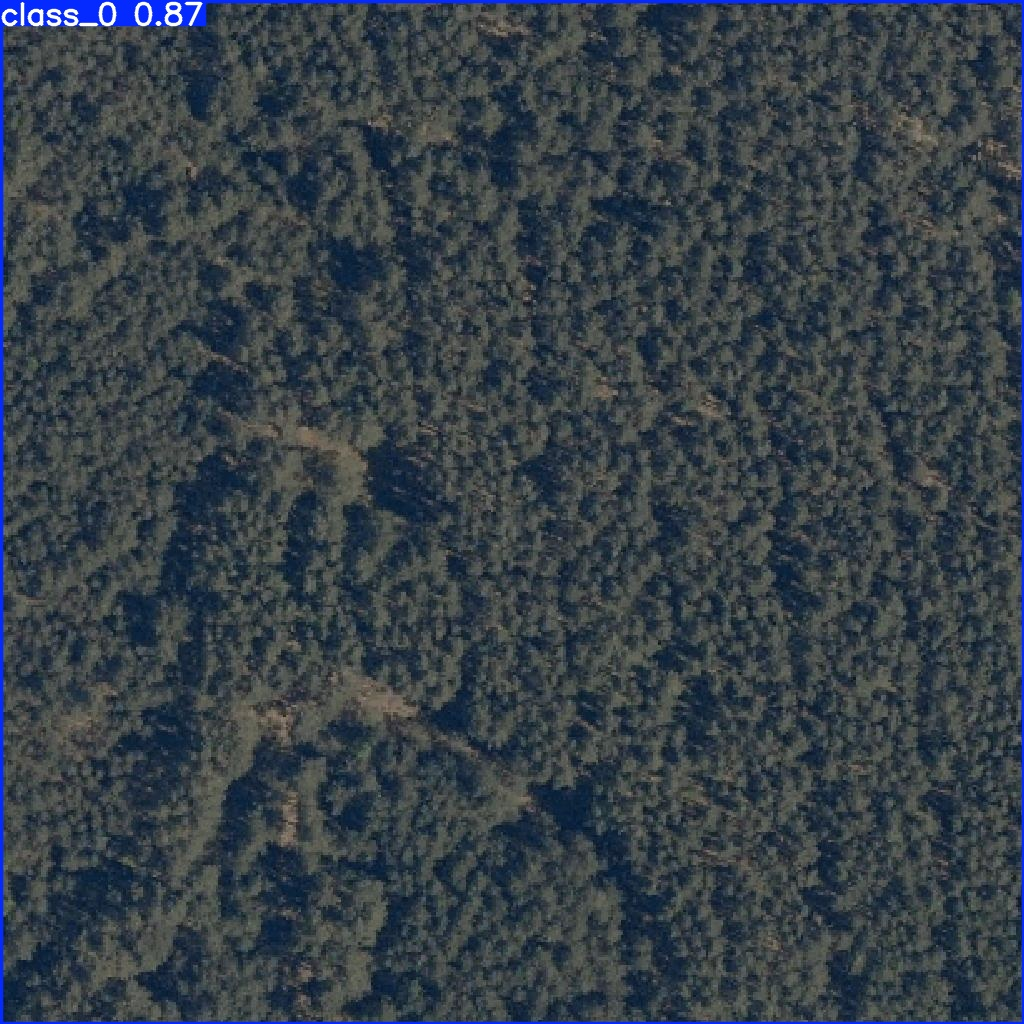

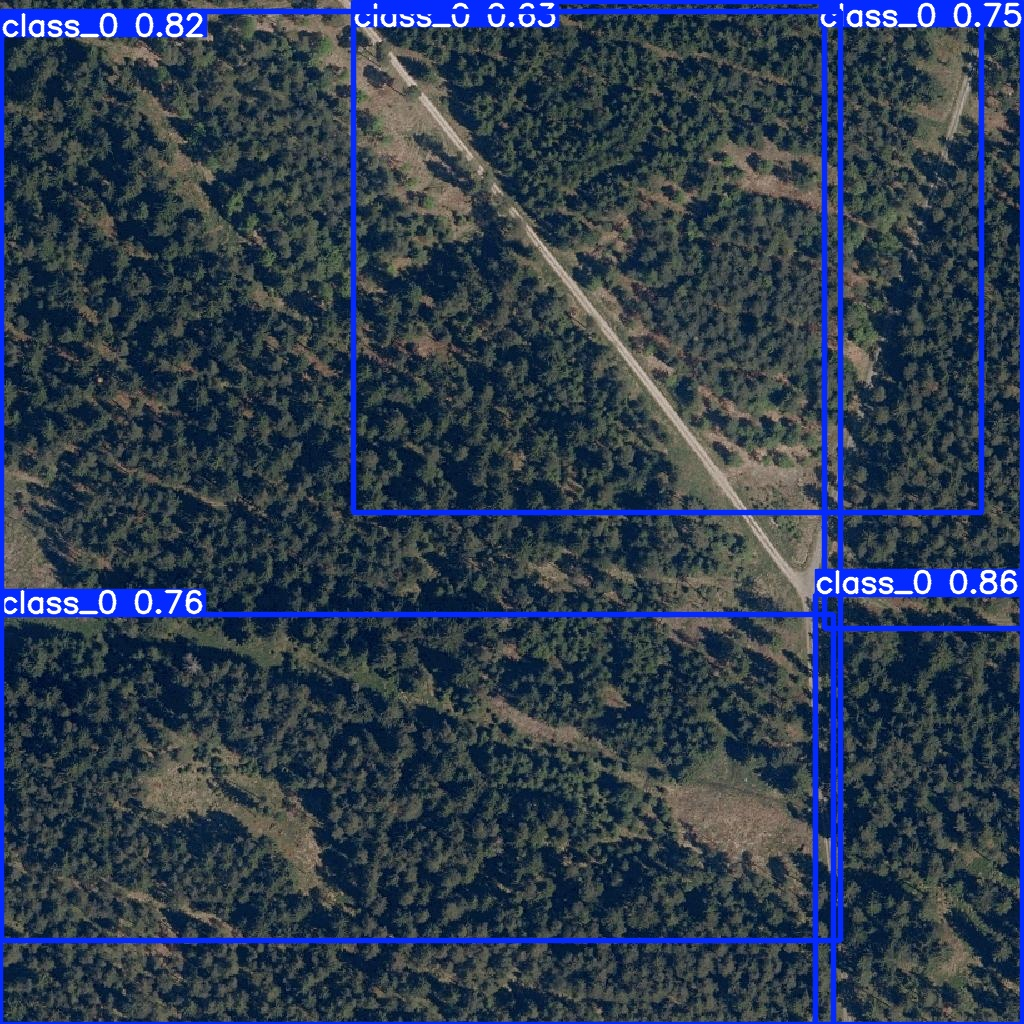

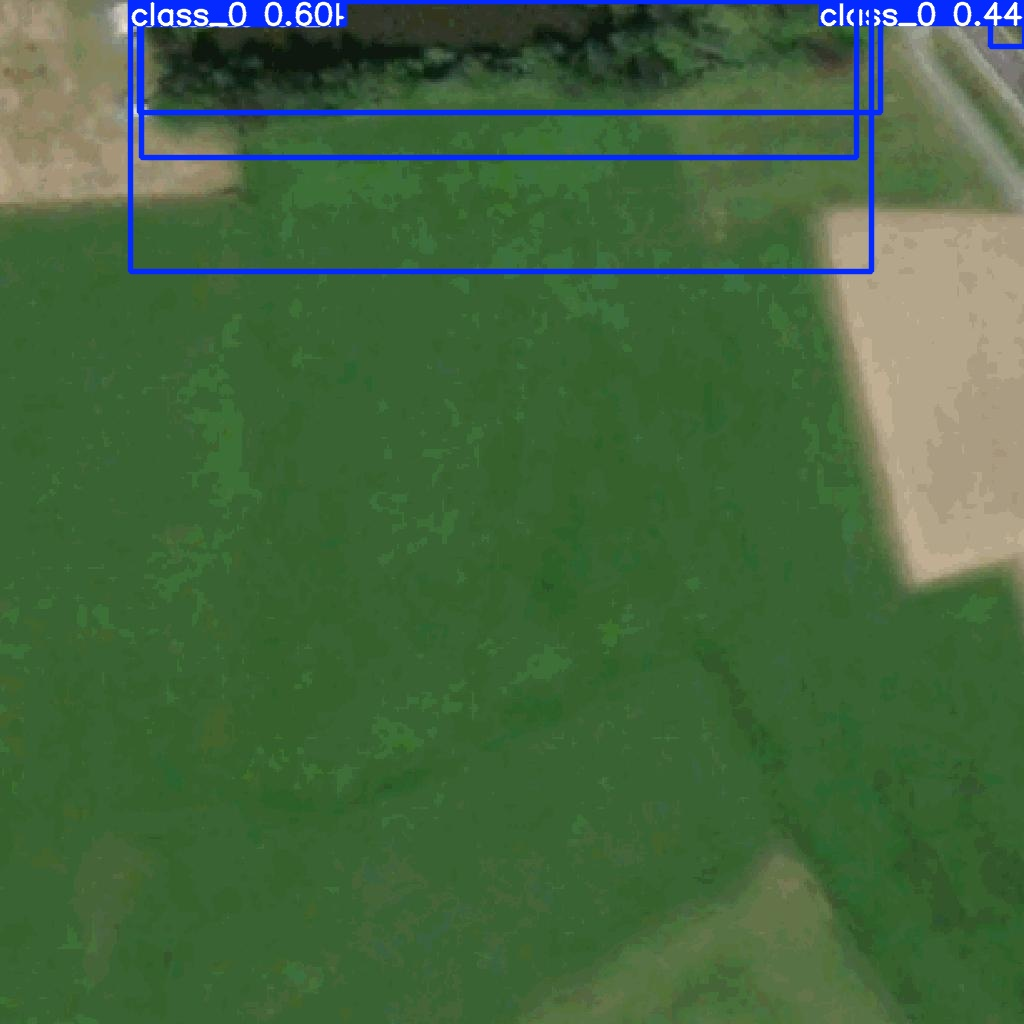

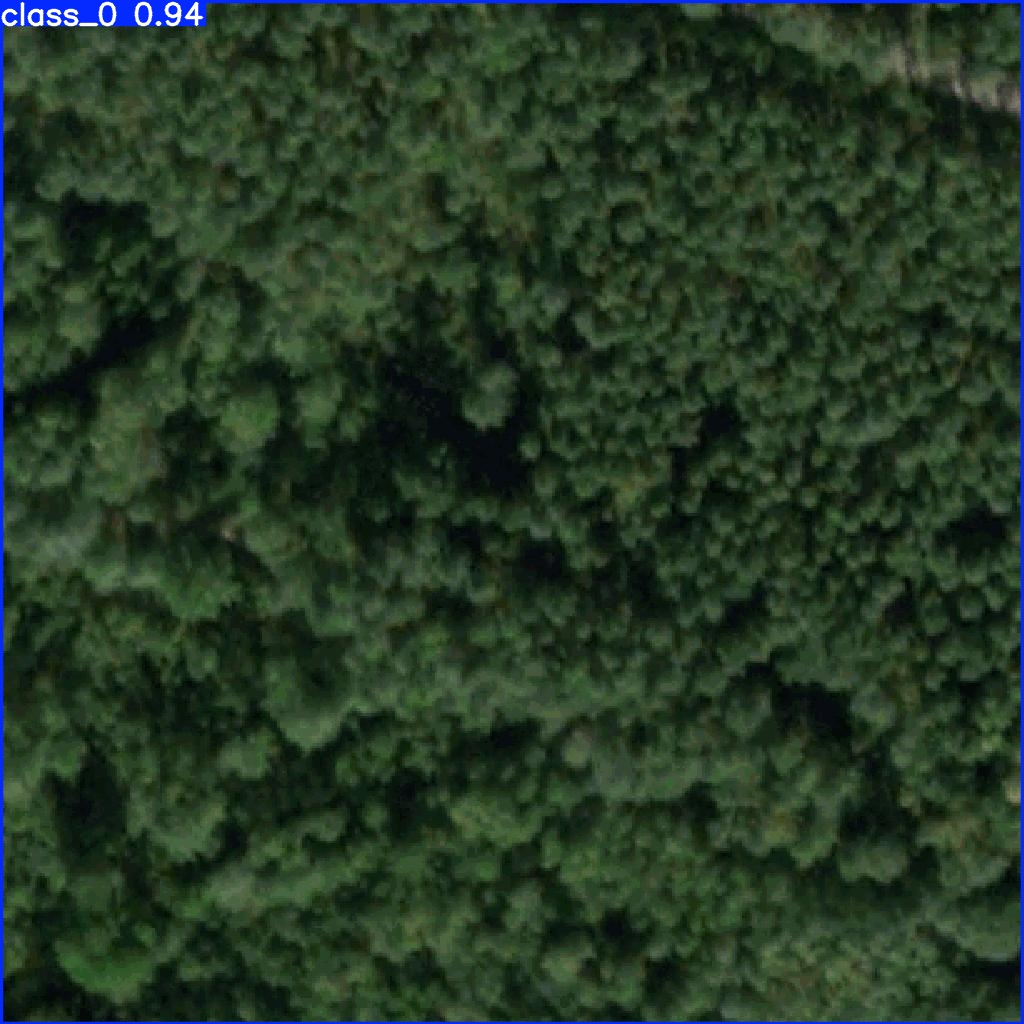

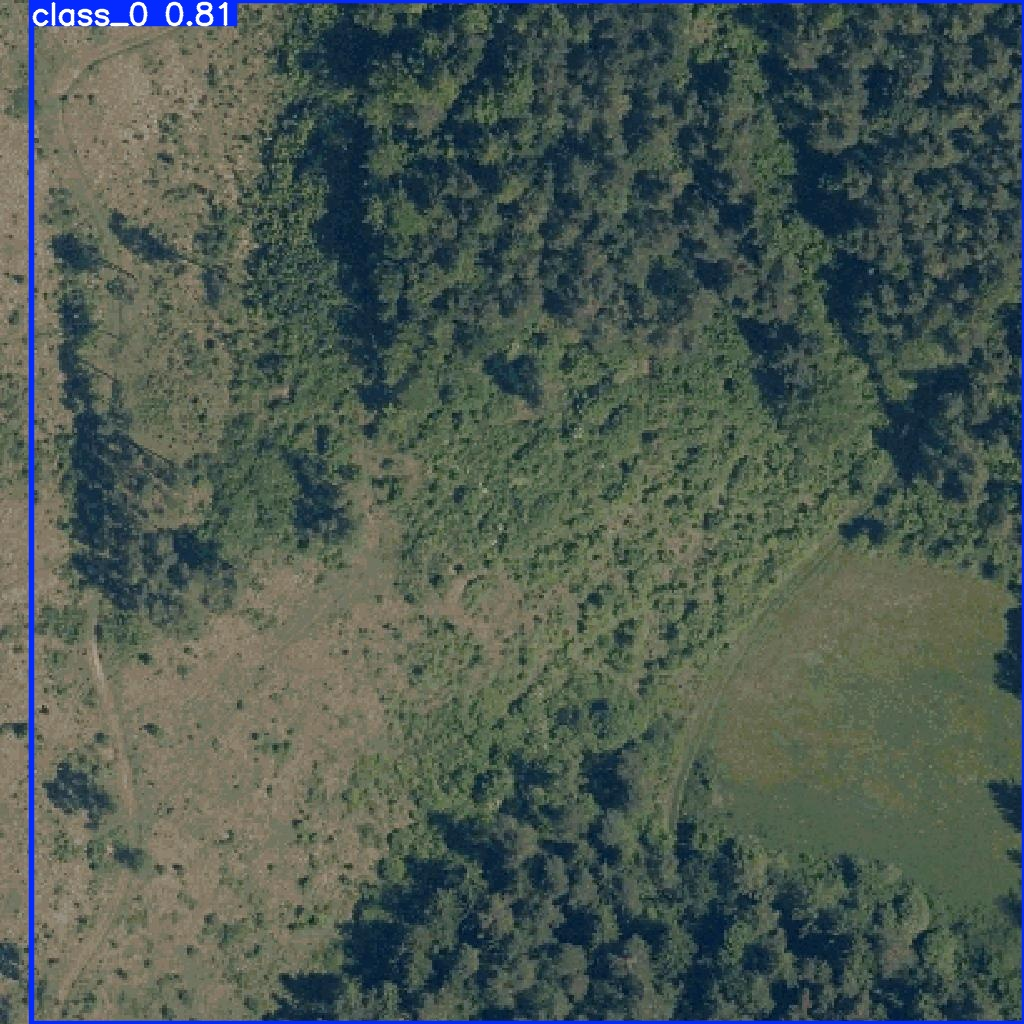

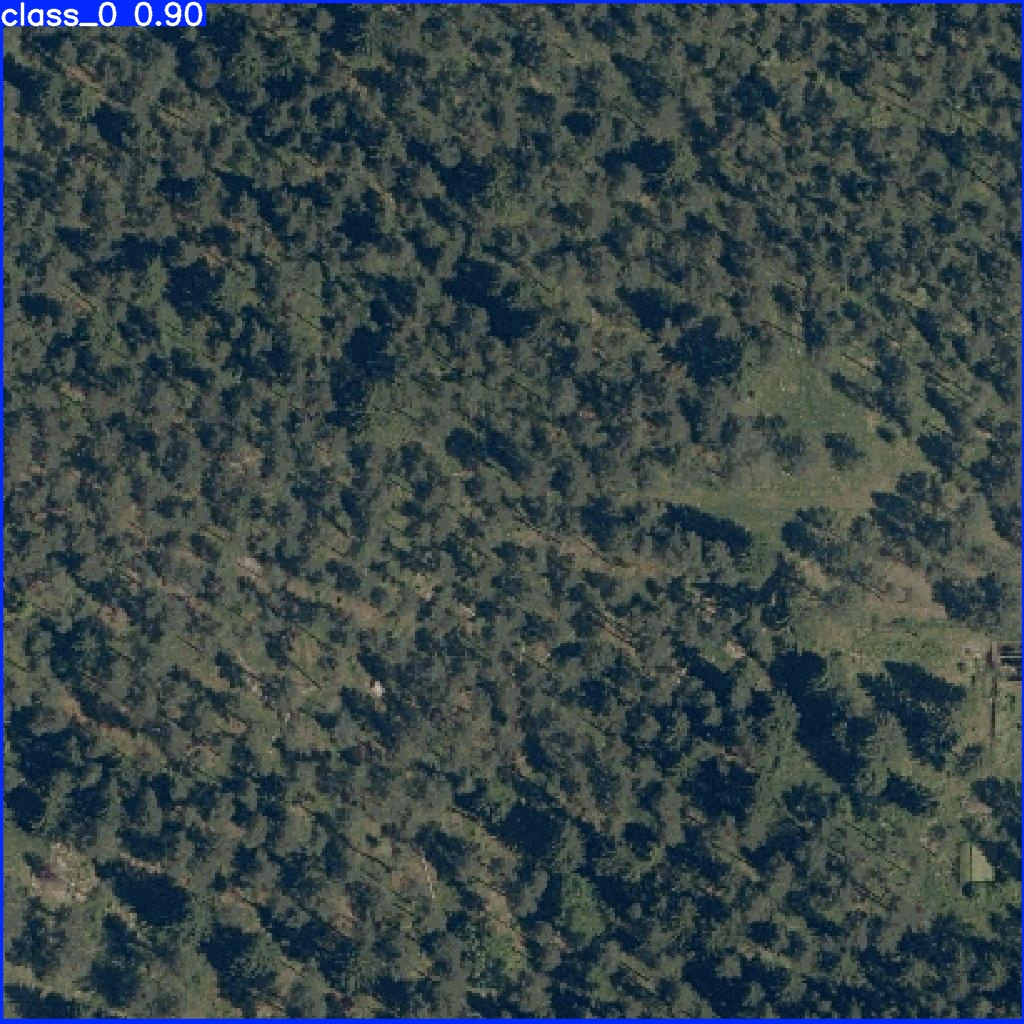

In [16]:
# ✅ FIXED: Display predicted images correctly
from IPython.display import Image, display
import glob

# find predicted image folder (usually under runs/detect/predict)
pred_dirs = glob.glob("/content/runs/**/predict", recursive=True)
img_list = []
for d in pred_dirs:
    img_list += glob.glob(f"{d}/*.*")

print(f"Found predicted images: {len(img_list)}")

# display first few predicted images
for img_path in img_list[:6]:
    display(Image(filename=img_path))


In [17]:
# 10. Copy best weights to Google Drive
drive_target = "/content/drive/MyDrive/vegetation_yolov8_best.pt"
# locate best.pt in runs folder
best_candidates = glob.glob("runs/**/weights/best.pt", recursive=True)
if best_candidates:
    best_path = best_candidates[0]
    print("Found best.pt:", best_path)
    # copy
    shutil.copy(best_path, drive_target)
    print("Copied best weights to", drive_target)
else:
    print("No best.pt found under runs/. Check runs/detect/<runname>/weights/")


Found best.pt: runs/detect/vegetation_yolov8/weights/best.pt
Copied best weights to /content/drive/MyDrive/vegetation_yolov8_best.pt


In [19]:
# 11. Export the trained model to ONNX and TorchScript (separately)

# Export to ONNX
onnx_path = model.export(format="onnx", imgsz=640)
print("✅ ONNX export completed:", onnx_path)

# Export to TorchScript
torchscript_path = model.export(format="torchscript", imgsz=640)
print("✅ TorchScript export completed:", torchscript_path)


Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)

PyTorch: starting from '/content/runs/detect/vegetation_yolov8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 5.5s, saved as '/content/runs/detect/vegetation_yolov8/weights/best.onnx' (11.7 MB)

Export complete (5.9s)
Results saved to /content/runs/detect/vegetation_yolov8/weights
Predict:         yolo predict task=detect model=/content/runs/detect/vegetation_yolov8/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/vegetation_yolov8/weights/best.onnx imgsz

Running programmatic predict on /content/vegetation_dataset/valid/images/0-78-28_png.rf.4e896038f5d538ed518940a24843ba61.jpg

image 1/1 /content/vegetation_dataset/valid/images/0-78-28_png.rf.4e896038f5d538ed518940a24843ba61.jpg: 640x640 1 class_0, 174.0ms
Speed: 5.2ms preprocess, 174.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

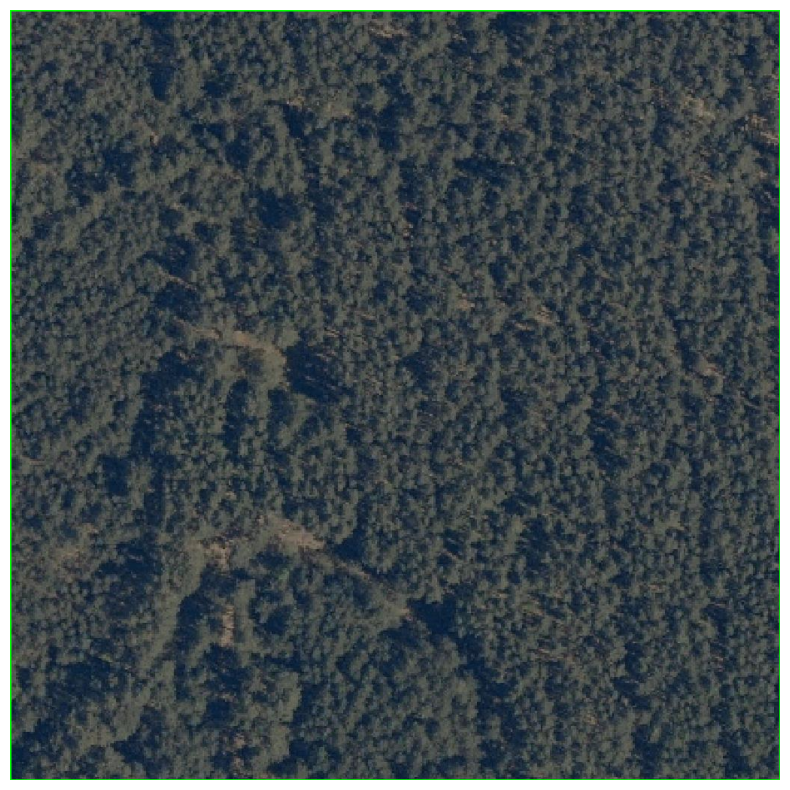

In [20]:
# 12. Programmatic inference & parsing results
img_path = glob.glob(os.path.join(paths["val_images"], "*"))[0]
print("Running programmatic predict on", img_path)
results = model.predict(source=img_path, imgsz=640, conf=0.25, save=False)[0]

# results.boxes holds detection boxes (if detection)
# Show image with boxes using OpenCV / matplotlib
import numpy as np
img = cv2.imread(img_path)
h,w = img.shape[:2]
if hasattr(results, "boxes") and len(results.boxes) > 0:
    boxes = results.boxes.xyxy.cpu().numpy()   # x1,y1,x2,y2
    probs = results.boxes.conf.cpu().numpy()
    cls_ids = results.boxes.cls.cpu().numpy().astype(int)
    for (x1,y1,x2,y2), p, cid in zip(boxes, probs, cls_ids):
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
        cv2.putText(img, f"{class_names[cid]} {p:.2f}", (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)
else:
    print("No boxes found on this result or it's a segmentation result.")

# display
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")


In [22]:
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Generate features for each image tile
def extract_features_for_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h,w = img.shape[:2]
    img_f = img.astype(np.float32)/255.0
    # basic features
    mean_r = img_f[:,:,0].mean()
    mean_g = img_f[:,:,1].mean()
    mean_b = img_f[:,:,2].mean()
    std_r = img_f[:,:,0].std()
    std_g = img_f[:,:,1].std()
    std_b = img_f[:,:,2].std()
    # ExG (excess green) as NDVI proxy for RGB
    exg = 2*img_f[:,:,1] - img_f[:,:,0] - img_f[:,:,2]
    exg_mean = exg.mean()
    # texture: sobel magnitude mean
    gx = cv2.Sobel(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cv2.CV_32F, 0, 1, ksize=3)
    sobel_mean = np.sqrt(gx*gx + gy*gy).mean()
    return {
        "mean_r": mean_r, "mean_g": mean_g, "mean_b": mean_b,
        "std_r": std_r, "std_g": std_g, "std_b": std_b,
        "exg_mean": exg_mean, "sobel_mean": sobel_mean
    }

# Build feature table for dataset/train
rows = []
labels = []  # user needs to provide a label for each image (0 stable,1 erosion-prone)
# For demonstration, we will attempt to read a CSV 'labels.csv' with columns: filename,label
label_csv = "labels.csv"  # If you have labels, create this file with filename,label
if os.path.exists(label_csv):
    df_label = pd.read_csv(label_csv)
    for _, r in df_label.iterrows():
        imgf = os.path.join("dataset","train","images", r['filename'])
        if not os.path.exists(imgf): continue
        feat = extract_features_for_image(imgf)
        feat['filename'] = r['filename']
        feat['label'] = int(r['label'])
        rows.append(feat)
else:
    print("labels.csv not found. Create a CSV with columns filename,label in Colab (filename relative to dataset/train/images).")

if rows:
    feat_df = pd.DataFrame(rows)
    X = feat_df.drop(columns=["filename","label"])
    y = feat_df["label"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = XGBClassifier(n_estimators=200, max_depth=6, use_label_encoder=False, eval_metric='logloss')
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, preds)
    print("Validation AUC:", auc)
    print(classification_report(y_val, clf.predict(X_val)))
    # save model
    import joblib
    joblib.dump(clf, "erosion_xgb.pkl")
else:
    print("No features built because labels.csv missing or empty. Add labels to run erosion model.")


labels.csv not found. Create a CSV with columns filename,label in Colab (filename relative to dataset/train/images).
No features built because labels.csv missing or empty. Add labels to run erosion model.


In [23]:
%%bash
cat > streamlit_app.py <<'PY'
import streamlit as st
from PIL import Image
import numpy as np
import torch
import cv2
from ultralytics import YOLO
import segmentation_models_pytorch as smp

st.title("Archaeological Site Mapping Demo")

uploaded_file = st.file_uploader("Upload an image", type=['png','jpg','jpeg','tif'])
if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Input image", use_column_width=True)
    # segmentation
    st.write("Running segmentation...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=3)
    model.load_state_dict(torch.load("best_unet.pth", map_location=device))
    model.to(device).eval()
    img_arr = np.array(img)
    inp = cv2.resize(img_arr, (256,256))
    inp = inp.astype('float32')/255.0
    inp = (inp - np.array([0.485,0.456,0.406]))/np.array([0.229,0.224,0.225])
    inp = np.transpose(inp, (2,0,1))[None,...]
    inp = torch.tensor(inp).float().to(device)
    with torch.no_grad():
        out = model(inp)
        pred = out.argmax(dim=1).cpu().numpy()[0]
    st.image(pred, caption="Segmentation (resized to 256x256)", use_column_width=True)

    # detection
    st.write("Running detection...")
    ymodel = YOLO("runs/detect/yolo_ruins/weights/best.pt")  # adjust path
    res = ymodel.predict(source=np.array(img), save=False)
    st.write("Detections:", res)
    # ultralytics saves annotated images; you could show them if available

PY
echo "Streamlit app written to streamlit_app.py"


Streamlit app written to streamlit_app.py
